<a href="https://colab.research.google.com/github/Vakurin/GANs-On-TensorFlow-2/blob/master/Second_GAN_DCGAN(Deep_Convolution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline(Bag Critical on TF 1.15 All Works and on TF 2.1 Only noise)
---
Main Topics Of This File:
* Batch Normalization
* Convolitional Layers(Conv2DTransp)

## Import Libs

In [2]:
# Make default version tf2.0 in colab
%tensorflow_version 2.x 

import tensorflow as tf
print(tf.__version__)
#keras = tf.keras

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

2.1.0


In [0]:
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Global Variables

In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Build Generator with Conv and Batch
* Conv2DTranspose - A transposed convolution essentially has a stride of less than one, such that the output dimensions are larger than the input dimension.
* I'll note that if you **use a kernel for conv2d, then use the same kernel for conv2d_transpose, you get the original image back.** You don't have to transpose the kernel.


In [0]:
def model_generator(z_dim):
  
  model = keras.models.Sequential(name='Generator')
  
  # Take a random noisy vector and reshape it in Tensor 
  model.add(keras.layers.Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(keras.layers.Reshape((7, 7, 256)))
  
  # 7x7x256 (Conv2D with stride=2) -> 14x14x128
  model.add(keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', name='First_Conv2DTrans'))
  model.add(keras.layers.BatchNormalization())
  # We used leakyRelu for activation function, it's makes a small negative gradient
  model.add(keras.layers.LeakyReLU(alpha=0.01))

  # Conv2D With Stride 1 Make a same height and width  14x14x128 -> 14x14x64
  model.add(keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same', name='SecondConv2DTrans'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=0.01))
  
  # 14x14x64 -> 28x28x1
  model.add(keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', name='ThirdConv2DTrans'))
  model.add(keras.layers.Activation('tanh', name='Output_Tanh'))
  

  return model

In [0]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

In [21]:
build_generator(z_dim=z_dim).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        2

## Build Disriminator
* If we don't using `padding='same' and stride=2` we got 28x28 -> 12x12

* **Model:**
28x28x1 -> 14x14x32 -> 7x7x64 -> 4x4x128 -> 2048 -> 1(prediction)

In [0]:
def model_discriminator(img_shape):
  model = keras.Sequential(name='Discriminator')
  
  model.add(keras.layers.Conv2D(32, 
                                kernel_size=3, 
                                strides=2,
                                padding='same',
                                input_shape=img_shape))
  model.add(keras.layers.LeakyReLU(alpha=0.01))

  model.add(keras.layers.Conv2D(64, 
                                kernel_size=3,
                                strides=2,
                                padding='same',
                                input_shape=img_shape))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=0.01))

  model.add(keras.layers.Conv2D(128, 
                                kernel_size=3,
                                strides=2,
                                padding='same',
                                input_shape=img_shape))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU(alpha=0.01))

  model.add(keras.layers.Flatten())
  # Prediction Layer Fake or Not 
  model.add(keras.layers.Dense(1, activation='sigmoid', name='Discriminator_Output'))

  return model

In [0]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [6]:
build_discriminator(img_shape).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         5

## Build GAN

In [0]:
def model_gan(generator, discriminator):
  model = Sequential(name='GAN')

  model.add(generator)
  model.add(discriminator)

  return model

In [0]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [0]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [0]:
discriminator = build_discriminator(img_shape)
discriminator.compile(
                      loss=tf.keras.losses.binary_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['acc'])

generator = build_generator(z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.binary_crossentropy)


In [7]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1637121   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 95489     
Total params: 1,732,610
Trainable params: 1,636,737
Non-trainable params: 95,873
_________________________________________________________________


## Visualisation Images After Each Epochs 

In [0]:
def sample_images(generator, iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    # Iteration Print 
    fig.suptitle('Iteration ' + str(iteration), fontsize="x-large")
    
    for i in range(image_grid_rows):    
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Training 

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator 
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            iter_print = (iteration + 1) // 1000
            # Output a sample of generated image
            sample_images(generator, iter_print)

## Start Training

1000 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.021230]
2000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.102354]
3000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.470693]
4000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.048420]
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.044494]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.032256]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.024292]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.019433]
9000 [D loss: 0.001666, acc.: 100.00%] [G loss: 0.194348]
10000 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.002290]
11000 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.000755]
12000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000335]
13000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000162]
14000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000072]
15000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000033]
16000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000014]
17000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000007]
18000 

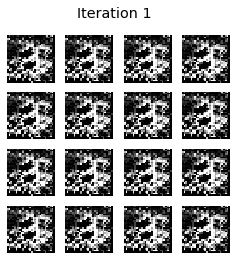

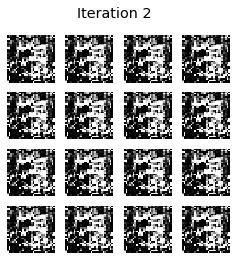

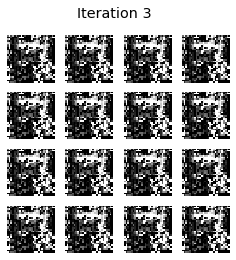

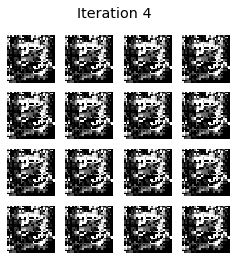

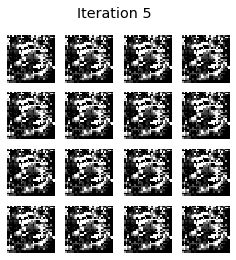

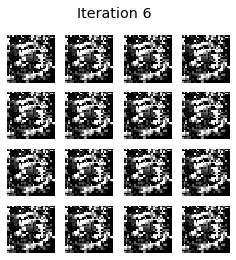

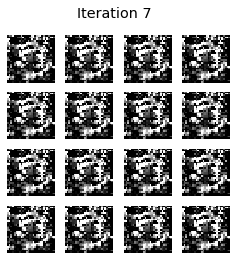

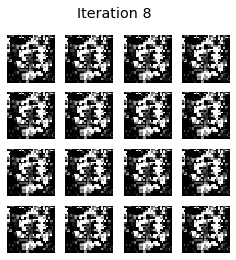

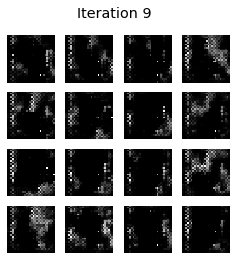

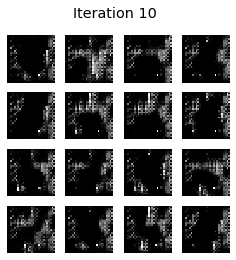

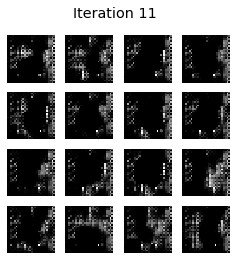

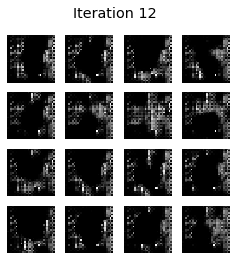

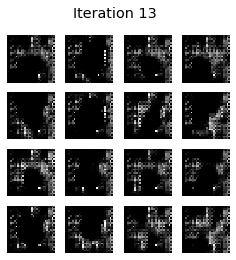

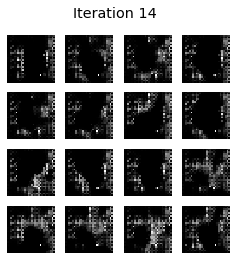

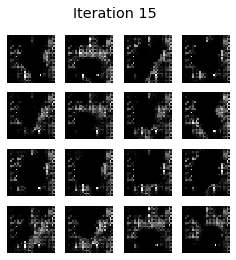

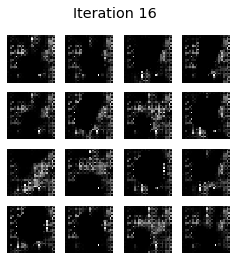

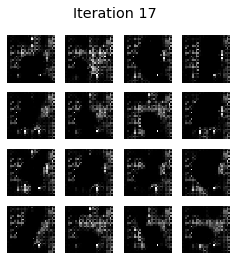

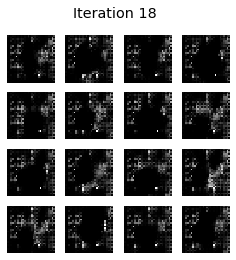

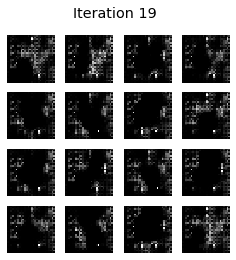

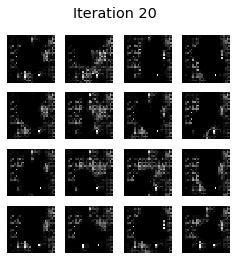

In [12]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

## Visualisation Loss

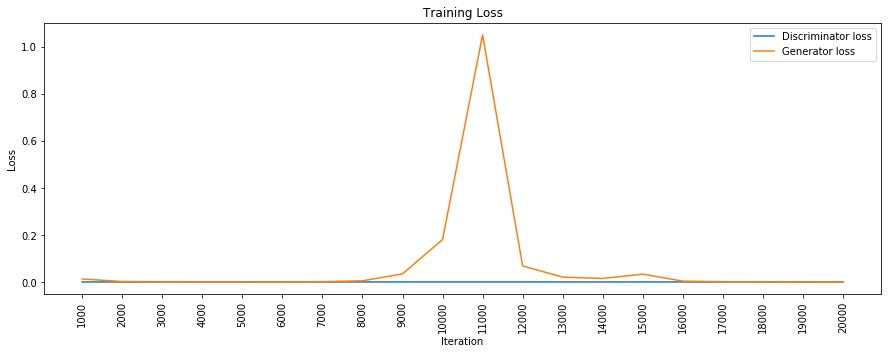

In [44]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend();

## Discriminator accuracy

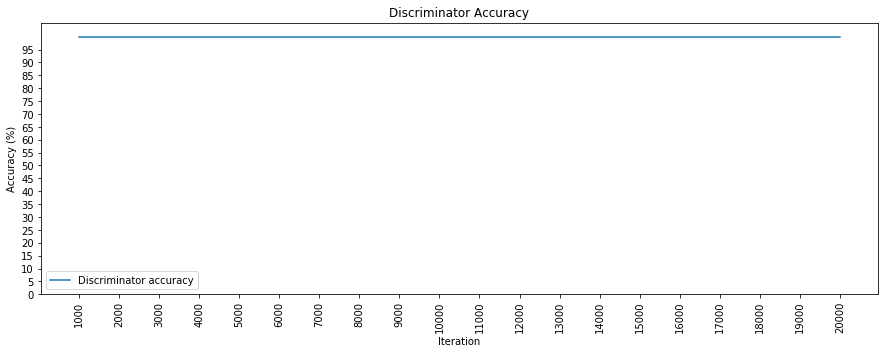

In [45]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend();